In [4]:
import climdata
import pandas as pd
import xarray as xr

# cfg_cmip, filename_cmip, ds_cmip = climdata.extract_data(
#     overrides=[
#             "dataset=cmip",
#             "experiment_id=historical",
#             "source_id=MIROC6",
#             "variables=[tas,tasmin,tasmax,pr,rsds,sfcWind]",
#             "table_id=day",
#             "data_dir=./data",
#             f"time_range.start_date=1989-01-01",
#             f"time_range.end_date=2020-12-31",
#             "bounds.custom={lat_min:35,lat_max:71,lon_min:-10,lon_max:31}",
#             "region=custom",
#     ]
# )

from concurrent.futures import ProcessPoolExecutor
import climdata

def extract_one(year):
    cfg, filename, ds = climdata.extract_data(
        overrides=[
            "dataset=mswx",
            "variables=[tas,tasmin,tasmax,pr,rsds]",
            "table_id=day",
            "data_dir=/beegfs/muduchuru/data",
            f"time_range.start_date={year}-01-01",
            f"time_range.end_date={year}-12-31",
            "bounds.custom={lat_min:35,lat_max:71,lon_min:-10,lon_max:31}",
            "region=custom",
            "dsinfo.mswx.params.google_service_account=/home/muduchuru/.climdata_conf/service.json",
        ]
    )
    return filename

variables = ["tas", "tasmin", "tasmax", "pr", "rsds"]
years = list(range(2020, 2021))

with ProcessPoolExecutor(max_workers=1) as exe:
    results = list(exe.map(extract_one, years))

print(results)


../../usecase/conf
✅ All 366 tas files already exist locally.
✅ All 366 tasmin files already exist locally.
✅ All 366 tasmax files already exist locally.
✅ All 366 pr files already exist locally.
✅ All 366 rsds files already exist locally.
✅ Saved output to mswx_surface_LAT35-71_LON-10-31_20200101_20201231.nc
['mswx_surface_LAT35-71_LON-10-31_20200101_20201231.nc']


In [2]:
import climdata
import pandas as pd
import xarray as xr
cfg_dwd, filename_dwd, ds_dwd = climdata.extract_data(
    overrides=[
            "dataset=dwd",
            "variables=[tas,tasmin,tasmax,pr,rsds,sfcWind]",
            "table_id=day",
            "data_dir=./data",
            f"time_range.start_date=1989-01-01",
            f"time_range.end_date=2020-12-31",
            "bounds.custom={lat_min:50,lat_max:52,lon_min:10,lon_max:13}",
            "region=custom",
    ]
)

import numpy as np
from imputegap.recovery.imputation import Imputation
from imputegap.recovery.manager import TimeSeries

# Extract multiple variables for a single station
custom_data = ds_dwd[['tas', 'pr', 'tasmin', 'tasmax']].isel(station_id=1).to_array("channel")

# Convert to NumPy and transpose: shape -> (n_series, seq_len)
# Currently shape is (channel, time), we want (series, time)
custom_data = np.asarray(custom_data)  # DataArray -> np.ndarray
custom_data = custom_data[:,:1024]  # still (channel, time)
# if needed, you can reshape: series = channels, seq_len = time
# already correct if channels = rows

# Initialize TimeSeries object
ts = TimeSeries()
ts.data = custom_data.copy()
ts.n_series, ts.seq_len = ts.data.shape  # (4, time)

# Optional: normalize
ts.normalize(normalizer="z_score")

# Contaminate the data (MCAR)
ts_m = ts.Contamination.mcar(ts.data)
ts_m = np.asarray(ts_m)  # ensure NumPy array

# CDRec imputation
imputer = Imputation.MatrixCompletion.CDRec(ts_m)
imputer.impute()

# Metrics
imputer.score(ts.data, imputer.recov_data)
ts.print_results(imputer.metrics)

# Plot
ts.plot(
    input_data=ts.data,
    incomp_data=ts_m,
    recov_data=imputer.recov_data,
    nbr_series=4,           # number of series = number of channels
    subplot=True,
    algorithm=imputer.algorithm
)


../../usecase/conf
✅ Saved output to dwd_surface_LAT50-52_LON10-13_19890101_20201231.nc
> logs: normalization (z_score) of the data - runtime: 0.0002 seconds

(CONT) missigness pattern: MCAR
	selected series: 2
	percentage of contaminated series: 20.0%
	rate of missing data per series: 20.0%
	block size: 10
	security offset: [0-102]
	seed value: 42
ERROR: Rank choosen to high for the number of series: 3 >= 4.
	Rank reduced to 2.

(IMPUTATION) CDRec
	Matrix: 4, 1024
	truncation rank: 2
	epsilon: 1e-06
	iterations: 100

> logs: imputation cdrec - Execution Time: 0.0215 seconds.

Results :
RMSE                 = 1.246958368465362
MAE                  = 1.0307731136520715
MI                   = 0.1808584535137215
CORRELATION          = 0.08070552239294562

plots saved in: ./imputegap_assets/25_11_24_11_59_53_cdrec_plot.jpg


'./imputegap_assets/25_11_24_11_59_53_cdrec_plot.jpg'

In [4]:
from dataclasses import dataclass
import numpy as np
import xarray as xr
from imputegap.wrapper.AlgoPython.BRITS.runnerBRITS import brits_recovery

@dataclass
class ImputationConfig:
    method: str = "brits"
    epoch: int = 10
    batch_size: int = 32
    hidden_layers: int = 64
    seq_length: int = 32
    verbose: bool = True

class Imputer:
    def __init__(self, config: ImputationConfig):
        self.config = config

    def impute(self, ds: xr.Dataset, vars, spatial_dims=None):
        if self.config.method == "brits":
            return self._impute_brits(ds, vars, spatial_dims)
        else:
            raise NotImplementedError(f"Method '{self.config.method}' not implemented.")

    def _impute_brits(self, ds: xr.Dataset, vars, spatial_dims=None):
        # -----------------------------
        # 1) Handle channel and spatial dimensions
        # -----------------------------
        if spatial_dims is None:
            spatial_dims = []
        channels = vars
        da_list = [ds[var] for var in vars]
        da = xr.concat(da_list, dim="channel").assign_coords(channel=channels)

        # Ensure spatial dims exist
        all_dims = ["time"] + spatial_dims + ["channel"]
        da = da.transpose(*all_dims)

        # Flatten spatial dims into 'pixel'
        if spatial_dims:
            flat = da.stack(pixel=spatial_dims)
        else:
            flat = da.expand_dims({'pixel': [0]})  # handle no spatial dims

        arr = flat.values  # (time, pixel, channel)
        T, P, C = arr.shape

        # Prepare input for BRITS: (samples=pixels, seq_len=time*channels)
        data_for_brits = np.transpose(arr, (1, 0, 2)).reshape(P, T * C)

        # Create mask of NaNs
        m_mask = np.isnan(data_for_brits)

        # -----------------------------
        # 2) Run BRITS
        # -----------------------------
        recovery = brits_recovery(
            incomp_data=data_for_brits,
            model=self.config.method,
            epoch=self.config.epoch,
            batch_size=self.config.batch_size,
            nbr_features=1,
            hidden_layers=self.config.hidden_layers,
            seq_length=self.config.seq_length,
            verbose=self.config.verbose,
        )

        # Reshape recovery to original (time, pixel, channel)
        recovery = recovery.reshape(P, T, C).transpose(1, 0, 2)

        # -----------------------------
        # 3) Reconstruct xarray Dataset
        # -----------------------------
        # Fill missing values only
        recov_arr = arr.copy()
        recov_arr[np.isnan(recov_arr)] = recovery[np.isnan(recov_arr)]

        # Build xarray DataArray
        if spatial_dims:
            imputed_flat = xr.DataArray(
                recov_arr,
                dims=("time", "pixel", "channel"),
                coords={
                    "time": ds.time,
                    "pixel": flat.pixel,
                    "channel": channels
                }
            )
            # Unstack pixels back to spatial dims
            imputed = imputed_flat.unstack("pixel")
        else:
            imputed = xr.DataArray(
                recov_arr[:, 0, :],
                dims=("time", "channel"),
                coords={"time": ds.time, "channel": channels}
            )

        # Split channels back into Dataset
        out_ds = imputed.to_dataset("channel")
        rename_dict = {v: channels[i] for i, v in enumerate(out_ds.data_vars)}
        return out_ds.rename(rename_dict)
import xarray as xr
import numpy as np

def check_nans(ds):
    """
    Check for NaNs in an xarray Dataset or DataArray.

    Parameters
    ----------
    ds : xr.Dataset or xr.DataArray
        Dataset or DataArray to check for missing values.

    Returns
    -------
    dict
        Dictionary with variable names as keys and a tuple (num_nans, pct_nans) as values.
    """
    results = {}

    if isinstance(ds, xr.DataArray):
        num_nans = np.isnan(ds.values).sum()
        pct_nans = 100.0 * num_nans / ds.size
        results[ds.name or "dataarray"] = (num_nans, pct_nans)
    elif isinstance(ds, xr.Dataset):
        for var in ds.data_vars:
            data = ds[var].values
            num_nans = np.isnan(data).sum()
            pct_nans = 100.0 * num_nans / data.size
            results[var] = (num_nans, pct_nans)
    else:
        raise TypeError("Input must be an xarray Dataset or DataArray.")

    return results
import xarray as xr
# ds_dwd = xr.open_dataset("dwd_surface_LAT35-71_LON-10-31_19890101_20201231.nc")
config = ImputationConfig(
    method="brits",
    epoch=100,
    batch_size=32,
    hidden_layers=64,
    seq_length=32,
    verbose=True
)

imputer = Imputer(config)
imputed_ds = imputer.impute(
    ds=ds_dwd.isel(station_id=[0])[['tas']].dropna("time"),
    vars=["tas"],
    spatial_dims=["station_id"]   # even with 1D spatial dimension
)

NameError: name 'ds_dwd' is not defined

In [44]:
import numpy as np
from imputegap.wrapper.AlgoPython.BRITS.runnerBRITS import brits_recovery
from imputegap.tools import utils

# 1) Keep NaNs, select single station
data_for_brits = ds_dwd.isel(station_id=[1])['tas'].data
data_for_brits, indices = trim_leading_and_training_nans(data_for_brits, n_train=0)
print("Original shape:", data_for_brits.shape)

nan_ratio = np.isnan(data_for_brits).mean()
print(f"NaN proportion: {nan_ratio*100:.2f}%")

# 2) Reshape to (pixels, sequence)
data_for_brits = data_for_brits.reshape(1, -1)

contaminated_data, mask_train, mask_test, mask_valid, error = utils.dl_integration_transformation(
    input_matrix=data_for_brits,
    tr_ratio=0.9,                    # proportion for training
    inside_tr_cont_ratio=0.2,        # 20% of training values are contaminated (NaN)
    split_ts=1,                       # treat as single time series
    split_val=0,                      # no validation split
    nan_val=-99999,                   # temporary fill value for NaNs
    prevent_leak=-99999,
    offset=0.05,
    seed=42,
    verbose=True
)
contaminated_data = contaminated_data.astype(float)
contaminated_data[contaminated_data == -99999] = np.nan

print("Reshaped for BRITS:", data_for_brits.shape)

# 3) Optional: check NaN proportion
nan_ratio = np.isnan(contaminated_data).mean()
print(f"NaN proportion: {nan_ratio*100:.2f}%")

# 4) Run BRITS
recov = brits_recovery(
    incomp_data=data_for_brits,
    model='brits',
    epoch=30,
    batch_size=32,
    nbr_features=1,
    hidden_layers=64,
    seq_length=32,
    verbose=True,
)

# 5) Flatten to 1D time series
# recov = recov.reshape(-1)

Original shape: (1, 11688)
NaN proportion: 0.18%

(DL) TEST-SET : testing ratio to reach = 10.00%

(DL) TEST-SET : original missing ratio = 0.18%
(DL) TEST-SET : original missing numbers = 21
(DL): TEST-SET > Test set fixed to 10% of the dataset, for 1168 values, add test values: 1147
(DL) TEST-SET : building of the test set to reach a fix ratio of 10.00%...
(DL) TEST-SET : final artificially missing ratio for test set = 9.99%
(DL) TEST-SET : final number of rows with NaN values = 1
(DL) TEST-SET : final artificially missing numbers = 1168


(DL) Reset all testing matrix values to -99999 to prevent data leakage.

(DL): MASKS > creating mask (testing, validation): Total NaNs = 1168
(DL): TEST-MASK > creating mask: Assigned to test = 1168
(DL): VALID-MASK > creating mask: Assigned to valid = 0
(DL): TEST-MASK > Test mask NaNs: 1168
(DL): VALID-MASK > Valid mask NaNs: 0

(DL): TRAIN-MASK > eligible entries: 9936
(DL): TRAIN-MASK > selected training entries: 2103

(DL): TRAIN-MASK > Train 

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [7]:
import numpy as np
from imputegap.recovery.imputation import Imputation
from imputegap.recovery.manager import TimeSeries
from imputegap.tools import utils


# 1) Keep NaNs, select single station
data_for_brits = ds_dwd['tas'].data
# data_for_brits, indices = trim_leading_and_training_nans(data_for_brits, n_train=0)
print("Original shape:", data_for_brits.shape)

nan_ratio = np.isnan(data_for_brits).mean()
print(f"NaN proportion: {nan_ratio*100:.2f}%")

# 2) Reshape to (pixels, sequence)
# data_for_brits = data_for_brits.reshape(1, -1)

contaminated_data, mask_train, mask_test, mask_valid, error = utils.dl_integration_transformation(
    input_matrix=data_for_brits,
    tr_ratio=0.9,                    # proportion for training
    inside_tr_cont_ratio=0.2,        # 20% of training values are contaminated (NaN)
    split_ts=1,                       # treat as single time series
    split_val=0,                      # no validation split
    nan_val=-99999,                   # temporary fill value for NaNs
    prevent_leak=-99999,
    offset=0.05,
    seed=42,
    verbose=True
)
contaminated_data = contaminated_data.astype(float)
contaminated_data[contaminated_data == -99999] = np.nan

print("Reshaped for BRITS:", data_for_brits.shape)

# 3) Optional: check NaN proportion
nan_ratio = np.isnan(contaminated_data).mean()
print(f"NaN proportion: {nan_ratio*100:.2f}%")
# Example data: a matrix with missing values
# shape: (n_series, seq_len) or (n_samples, n_features)

# Create Imputation object for CDRec
cdrec = Imputation.MatrixCompletion.CDRec(contaminated_data)

# Optionally define parameters: rank, epsilon, iterations
params = {
    "rank": 2,
    "epsilon": 0.01,
    "iterations": 100
}

# Run imputation
cdrec.impute(params=params)

# Get the imputed matrix
imputed = cdrec.recov_data


# import matplotlib.pyplot as plt
# plt.plot(imputed.T)
# plt.plot(data_for_brits.T)
# If you have ground truth, you can score
# Suppose ground_truth is the full matrix before you introduced NaNs
# cdrec.score(ground_truth, imputed)


Original shape: (30, 11688)
NaN proportion: 38.37%

(DL) TEST-SET : testing ratio to reach = 10.00%

(DL) TEST-SET : original missing ratio = 38.37%
(DL) TEST-SET : original missing numbers = 134538

(ERROR) The proportion of original missing values is too high and will corrupt the training set.
	Please consider reducing the percentage contamination pattern [38.37%] or decreasing the training ratio [90.00%].


(DL) Reset all testing matrix values to -99999 to prevent data leakage.

(DL): MASKS > creating mask (testing, validation): Total NaNs = 134538
(DL): TEST-MASK > creating mask: Assigned to test = 134538
(DL): VALID-MASK > creating mask: Assigned to valid = 0
(DL): TEST-MASK > Test mask NaNs: 134538
(DL): VALID-MASK > Valid mask NaNs: 0

(DL): TRAIN-MASK > eligible entries: 203051
(DL): TRAIN-MASK > selected training entries: 44114

(DL): TRAIN-MASK > Train mask NaNs: 44114

Reshaped for BRITS: (30, 11688)
NaN proportion: 38.37%

(IMPUTATION) CDRec
	Matrix: 30, 11688
	truncation r

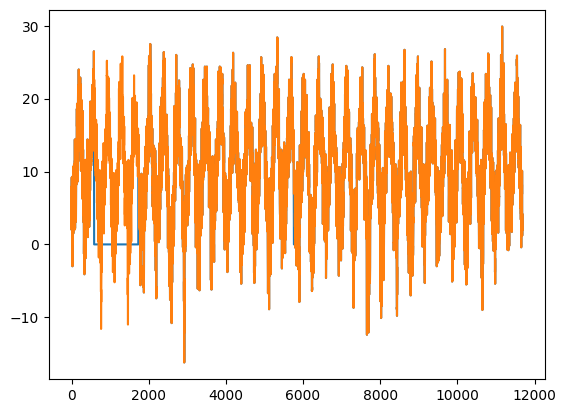

In [50]:
import matplotlib.pyplot as plt
plt.plot(imputed.T)
plt.plot(data_for_brits.T)

In [ ]:
custom_data = ds_dwd[['tas', 'pr', 'tasmin', 'tasmax']].isel(station_id=1).to_array("channel")
custom_data

(4, 11688)

NameError: name 'ds_dwd' is not defined

In [32]:
import numpy as np

def trim_leading_and_training_nans(arr: np.ndarray, n_train: int = 0):
    """
    Remove leading NaNs and the first n_train valid values from a 1D or 2D array.

    Parameters
    ----------
    arr : np.ndarray
        Input array. Shape can be (time,) or (samples, time).
    n_train : int
        Number of initial valid entries to remove (simulating training cut).

    Returns
    -------
    trimmed_arr : np.ndarray
        Array with leading NaNs and first n_train values removed.
    keep_indices : np.ndarray
        Indices of the original array that were kept.
    """
    arr = np.asarray(arr)
    
    if arr.ndim == 1:
        # Find first non-NaN
        first_valid = np.argmax(~np.isnan(arr))
        start_idx = first_valid + n_train
        trimmed_arr = arr[start_idx:]
        keep_indices = np.arange(start_idx, arr.shape[0])
    
    elif arr.ndim == 2:
        # Assume shape (samples, time)
        keep_indices = []
        trimmed_list = []
        for i in range(arr.shape[0]):
            row = arr[i]
            first_valid = np.argmax(~np.isnan(row))
            start_idx = first_valid + n_train
            trimmed_list.append(row[start_idx:])
            keep_indices.append(np.arange(start_idx, arr.shape[1]))
        trimmed_arr = np.array(trimmed_list)
    else:
        raise ValueError("Only 1D or 2D arrays are supported.")
    
    return trimmed_arr, np.array(keep_indices)
data = np.array([np.nan, np.nan, 1.0, 2.0,np.nan,np.nan,np.nan, 3.0, 4.0,np.nan,np.nan,np.nan])
trimmed, indices = trim_leading_and_training_nans(data, n_train=0)
print(trimmed)  # [2.0, 3.0, 4.0]
print(indices)  # [3 4 5]


[ 1.  2. nan nan nan  3.  4. nan nan nan]
[ 2  3  4  5  6  7  8  9 10 11]


In [12]:
import os
from hydra import initialize, compose
from omegaconf import DictConfig
from climdata.utils.utils_download import get_output_filename

overrides=[
        "dataset=dwd",
        "variables=[tas]",
        "data_dir=./data",
        f"time_range.start_date=1989-01-01",
        f"time_range.end_date=2020-12-31",
        "bounds.custom={lat_min:47,lat_max:55,lon_min:5,lon_max:16}",
        "region=custom",
]
# conf_dir = climdata.utils.config._ensure_local_conf()  # copies conf/ to cwd
# rel_conf_dir = os.path.relpath(conf_dir, os.path.dirname(__file__))
# print(rel_conf_dir)
# 2. Initialize Hydra only if not already initialized
# if not GlobalHydra.instance().is_initialized():
hydra_context = initialize(config_path='conf', version_base=None)
# else:
# If already initialized, just set context to None for clarity
# hydra_context = None

# Use compose within context manager if newly initialized
cfg_name = 'config.yaml'
if hydra_context is not None:
    with hydra_context:
        cfg: DictConfig = compose(config_name=cfg_name, overrides=overrides)
else:
    # Already initialized: compose directly
    cfg: DictConfig = compose(config_name=cfg_name, overrides=overrides)
extract_kwargs = {}
filename = None
# Determine extraction type
if cfg.lat is not None and cfg.lon is not None:
    extract_kwargs["point"] = (cfg.lon, cfg.lat)
    filename = get_output_filename(cfg, output_type="csv", lat=cfg.lat, lon=cfg.lon)
elif cfg.region is not None:
    extract_kwargs["box"] = cfg.bounds[cfg.region]
    filename = get_output_filename(cfg, output_type="nc")
elif cfg.shapefile is not None:
    extract_kwargs["shapefile"] = cfg.shapefile
    filename = get_output_filename(cfg, output_type="nc", shp_name=cfg.shp_name)

dataset_upper = cfg.dataset.upper()

ds_vars = []
for var in cfg.variables:
    dwd = climdata.DWD(cfg)
    # lat_val, lon_val = lat, lon
    extract_kwargs['variable'] = var
    extract_kwargs["buffer_km"] = 50
    ds = dwd.extract(**extract_kwargs)
    # dwd.format(var, lat_val, lon_val)
    ds_vars.append(ds)
ds = xr.merge(ds_vars)

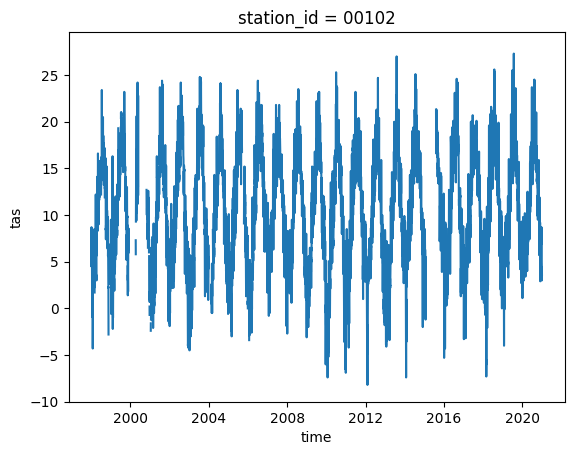

In [31]:
import numpy as np
# np.where(ds['quality_tas']<9)
ds.isel(station_id=9)['tas'].plot()

In [ ]:
path_bonn_weather = "/beegfs/common/data/climate/dwd/csvs/germany_ubn_1951-01-01_to_2024-08-30/1/daily_mean_RES1_C180R1.csv.gz"
df_bonn_weather = pd.read_csv(path_bonn_weather, sep='\s+', compression="gzip")



In [5]:
df_bonn_weather

,Date,Precipitation,TempMin,TempMean,TempMax,Radiation,SunshineDuration,SoilMoisture,SoilTemperature,Windspeed,RefETcalc,RefETdwd,RelHumCalc,Gridcell
0,1951-01-01,1.4,-7.5,-2.4,1.1,1313,0.0,-999.0,-999.0,2.7,0.7,-999.0,69,C_180:R_1
1,1951-01-02,3.8,-1.3,0.1,1.2,1326,0.0,-999.0,-999.0,2.5,0.4,-999.0,87,C_180:R_1
2,1951-01-03,0.3,-0.7,1.1,2.3,1340,0.0,-999.0,-999.0,1.8,0.4,-999.0,86,C_180:R_1
3,1951-01-04,2.4,-0.2,1.5,3.2,1396,0.1,-999.0,-999.0,2.6,0.5,-999.0,85,C_180:R_1
4,1951-01-05,12.1,1.0,3.0,4.3,1372,0.0,-999.0,-999.0,3.1,0.5,-999.0,85,C_180:R_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26901,2024-08-26,0.5,15.6,17.8,19.3,13450,4.6,75.0,17.9,1.6,2.3,2.0,86,C_180:R_1
26902,2024-08-27,0.0,15.7,19.0,22.0,22687,12.4,73.0,20.4,1.7,3.7,2.8,79,C_180:R_1
26903,2024-08-28,0.0,16.2,20.3,25.3,23236,13.0,71.0,21.6,1.8,4.2,3.1,72,C_180:R_1
26904,2024-08-29,0.0,15.5,19.8,25.4,16898,7.8,70.0,22.3,1.6,3.4,2.4,70,C_180:R_1
